# Import Library

In [1]:
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GATConv, GCNConv
from spektral.transforms import AdjToSpTensor, LayerPreprocess

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from models_new import (
    GCN,
)
    
from utils import (
    seed_everything, 
    limit_data, 
    encode_label, 
    normalize_Adj,
    draw_history,
    plot_tSNE,
)
import config as C

#### Set Seed

In [2]:
seed_everything(C.SEED)

# Load Data

In [3]:
dataset = Citation(
    "cora", normalize_x=True, transforms=[LayerPreprocess(GATConv), AdjToSpTensor()]
)


def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)


weights_tr, weights_va, weights_te = (
    mask_to_weights(mask)
    for mask in (dataset.mask_tr, dataset.mask_va, dataset.mask_te)
)

classes = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory']

Pre-processing node features


/home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [4]:
loader_all = SingleLoader(dataset)

loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)
loader_te = SingleLoader(dataset, sample_weights=weights_te)

x, y, w = next(iter(loader_te))
x[0].shape, y.shape, w.shape

((2708, 1433), (2708, 7), (2708,))

In [5]:
acc = []

# GCN

#### Build Model

In [6]:
gcn_model = GCN(C.dropout,
                        activation='relu',
                        conv_activation='relu',
                        mode=None,
                        sc=None)

gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/200
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 1s 1s/step - loss: 1.9695 - acc: 0.1500 - val_loss: 1.9018 - val_acc: 0.2960
Epoch 2/200
1/1 [==============================] - 0s 33ms/step - loss: 1.9040 - acc: 0.3071 - val_loss: 1.8285 - val_acc: 0.5280
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 1.8122 - acc: 0.4571 - val_loss: 1.7039 - val_acc: 0.5540
Epoch 4/200
1/1 [==============================] - 0s 32ms/step - loss: 1.6817 - acc: 0.5786 - val_loss: 1.6086 - val_acc: 0.5540
Epoch 5/200
1/1 [==============================] - 0s 30ms/step - loss: 1.6236 - acc: 0.5571 - val_loss: 1.5375 - val_acc: 0.5760
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - loss: 1.6566 - acc: 0.4500 - val_loss: 1.4902 - val_acc: 0.6060
Epoch 7/200
1/1 [==============================] - 0s 30ms/step - loss: 1.

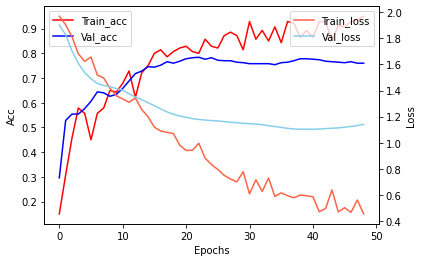

In [7]:
gcn_history = gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=C.epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=C.es_patience, restore_best_weights=True)]
)

draw_history(gcn_history, 'GCN', issave=False)

#### Evaluate

In [8]:
y_pred = gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.69      0.75      0.72       351
    Genetic_Algorithms       0.77      0.84      0.81       217
       Neural_Networks       0.87      0.88      0.88       418
 Probabilistic_Methods       0.87      0.75      0.80       818
Reinforcement_Learning       0.79      0.77      0.78       426
         Rule_Learning       0.72      0.82      0.76       298
                Theory       0.67      0.76      0.71       180

              accuracy                           0.79      2708
             macro avg       0.77      0.80      0.78      2708
          weighted avg       0.80      0.79      0.79      2708



#### Visualization

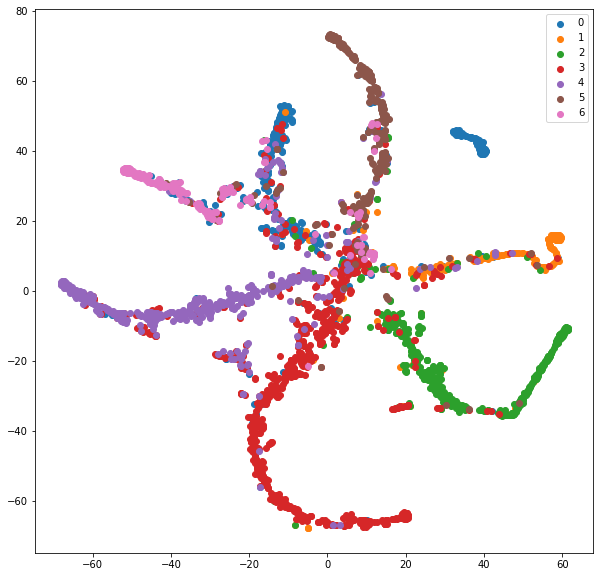

In [9]:
activ = gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Inception GCN

#### Build Model

In [10]:
inception_gcn_model = GCN(C.dropout,
                        activation='relu',
                        conv_activation='relu',
                        mode='inception',
                        sc=None)

inception_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
Instructions for updating:
Use `tf.linalg.matmul` instead
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 1s 721ms/step - loss: 441.1981 - acc: 0.1857 - val_loss: 212.3472 - val_acc: 0.1600
Epoch 2/1000
1/1 [==============================] - 0s 108ms/step - loss: 164.3209 - acc: 0.1786 - val_loss: 76.1557 - val_acc: 0.2480
Epoch 3/1000
1/1 [==============================] - 0s 118ms/step - loss: 137.0821 - acc: 0.2857 - val_loss: 225.8366 - val_acc: 0.2440
Epoch 4/1000
1/1 [==============================] - 0s 117ms/step - loss: 939.4357 - acc: 0.1786 - val_loss: 460.3566 - val_acc: 0.2840
Epoch 5/1000
1/1 [==============================] - 0s 106ms/step - loss: 595.0559 - acc: 0.1143 - val_loss: 396.9923 - val_acc: 0.2920
Epoch 6/1000
1/1 [==============================] - 0s 121ms/step - loss: 870.5897 - acc: 0.1214 - val_loss: 225.67

1/1 [==============================] - 0s 115ms/step - loss: 3.0599 - acc: 0.3071 - val_loss: 4.5118 - val_acc: 0.3100
Epoch 50/1000
1/1 [==============================] - 0s 100ms/step - loss: 2.6456 - acc: 0.2714 - val_loss: 4.3102 - val_acc: 0.3180
Epoch 51/1000
1/1 [==============================] - 0s 100ms/step - loss: 2.1011 - acc: 0.3571 - val_loss: 4.1468 - val_acc: 0.3300
Epoch 52/1000
1/1 [==============================] - 0s 118ms/step - loss: 2.8602 - acc: 0.3286 - val_loss: 3.9819 - val_acc: 0.3400
Epoch 53/1000
1/1 [==============================] - 0s 104ms/step - loss: 2.6539 - acc: 0.3000 - val_loss: 3.8261 - val_acc: 0.3380
Epoch 54/1000
1/1 [==============================] - 0s 99ms/step - loss: 2.0365 - acc: 0.3143 - val_loss: 3.6869 - val_acc: 0.3380
Epoch 55/1000
1/1 [==============================] - 0s 111ms/step - loss: 2.1309 - acc: 0.3143 - val_loss: 3.5544 - val_acc: 0.3360
Epoch 56/1000
1/1 [==============================] - 0s 104ms/step - loss: 3.0208 - 

Epoch 111/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.4623 - acc: 0.6000 - val_loss: 1.7743 - val_acc: 0.5460
Epoch 112/1000
1/1 [==============================] - 0s 113ms/step - loss: 1.5043 - acc: 0.5429 - val_loss: 1.7488 - val_acc: 0.5620
Epoch 113/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.4094 - acc: 0.6286 - val_loss: 1.7273 - val_acc: 0.5800
Epoch 114/1000
1/1 [==============================] - 0s 106ms/step - loss: 1.4822 - acc: 0.6500 - val_loss: 1.7094 - val_acc: 0.5940
Epoch 115/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.3446 - acc: 0.5857 - val_loss: 1.6939 - val_acc: 0.5860
Epoch 116/1000
1/1 [==============================] - 0s 105ms/step - loss: 1.3241 - acc: 0.6571 - val_loss: 1.6978 - val_acc: 0.5600
Epoch 117/1000
1/1 [==============================] - 0s 105ms/step - loss: 1.3011 - acc: 0.5929 - val_loss: 1.7357 - val_acc: 0.5480
Epoch 118/1000
1/1 [==============================] - 0s 105ms/s

1/1 [==============================] - 0s 98ms/step - loss: 1.0530 - acc: 0.6929 - val_loss: 1.7576 - val_acc: 0.6320
Epoch 173/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.0939 - acc: 0.6929 - val_loss: 1.7607 - val_acc: 0.6300
Epoch 174/1000
1/1 [==============================] - 0s 100ms/step - loss: 1.0647 - acc: 0.6857 - val_loss: 1.7640 - val_acc: 0.6320
Epoch 175/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.0990 - acc: 0.6643 - val_loss: 1.7636 - val_acc: 0.6360
Epoch 176/1000
1/1 [==============================] - 0s 100ms/step - loss: 1.0995 - acc: 0.6857 - val_loss: 1.7747 - val_acc: 0.6280
Epoch 177/1000
1/1 [==============================] - 0s 106ms/step - loss: 1.0797 - acc: 0.7143 - val_loss: 1.7779 - val_acc: 0.6280
Epoch 178/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.0724 - acc: 0.6929 - val_loss: 1.7701 - val_acc: 0.6300
Epoch 179/1000
1/1 [==============================] - 0s 98ms/step - loss: 1.114

1/1 [==============================] - 0s 98ms/step - loss: 0.9209 - acc: 0.7929 - val_loss: 1.7720 - val_acc: 0.6820
Epoch 234/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.8812 - acc: 0.8357 - val_loss: 1.7921 - val_acc: 0.6800
Epoch 235/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.8626 - acc: 0.8214 - val_loss: 1.7728 - val_acc: 0.6780
Epoch 236/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.8297 - acc: 0.8500 - val_loss: 1.7649 - val_acc: 0.6720
Epoch 237/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.8732 - acc: 0.8714 - val_loss: 1.7624 - val_acc: 0.6740
Epoch 238/1000
1/1 [==============================] - 0s 102ms/step - loss: 0.8593 - acc: 0.8286 - val_loss: 1.7602 - val_acc: 0.6800
Epoch 239/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.8251 - acc: 0.8286 - val_loss: 1.7535 - val_acc: 0.6820
Epoch 240/1000
1/1 [==============================] - 0s 100ms/step - loss: 0.847

1/1 [==============================] - 0s 100ms/step - loss: 0.8574 - acc: 0.8357 - val_loss: 1.7475 - val_acc: 0.7140
Epoch 295/1000
1/1 [==============================] - 0s 102ms/step - loss: 0.7757 - acc: 0.8643 - val_loss: 1.7531 - val_acc: 0.7140
Epoch 296/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.7738 - acc: 0.8643 - val_loss: 1.7795 - val_acc: 0.7080
Epoch 297/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.8170 - acc: 0.8571 - val_loss: 1.8062 - val_acc: 0.7140
Epoch 298/1000
1/1 [==============================] - 0s 106ms/step - loss: 0.7843 - acc: 0.8643 - val_loss: 1.8320 - val_acc: 0.7100
Epoch 299/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.7803 - acc: 0.8643 - val_loss: 1.8424 - val_acc: 0.7060
Epoch 300/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.8326 - acc: 0.8500 - val_loss: 1.8171 - val_acc: 0.7080
Epoch 301/1000
1/1 [==============================] - 0s 100ms/step - loss: 0.83

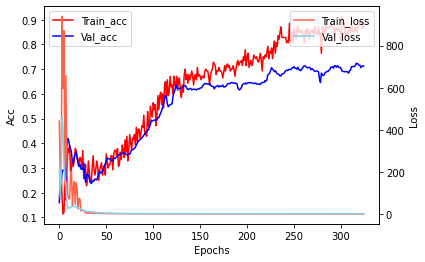

In [11]:
inception_gcn_history = inception_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]
)

draw_history(inception_gcn_history, 'InceptionGCN', issave=False)

#### Evaluate

In [12]:
y_pred = inception_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Inception GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Inception GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.55      0.46      0.50       351
    Genetic_Algorithms       0.50      0.80      0.62       217
       Neural_Networks       0.79      0.87      0.83       418
 Probabilistic_Methods       0.80      0.69      0.74       818
Reinforcement_Learning       0.76      0.72      0.74       426
         Rule_Learning       0.27      0.01      0.03       298
                Theory       0.28      0.74      0.40       180

              accuracy                           0.63      2708
             macro avg       0.56      0.61      0.55      2708
          weighted avg       0.64      0.63      0.61      2708



#### Visualization

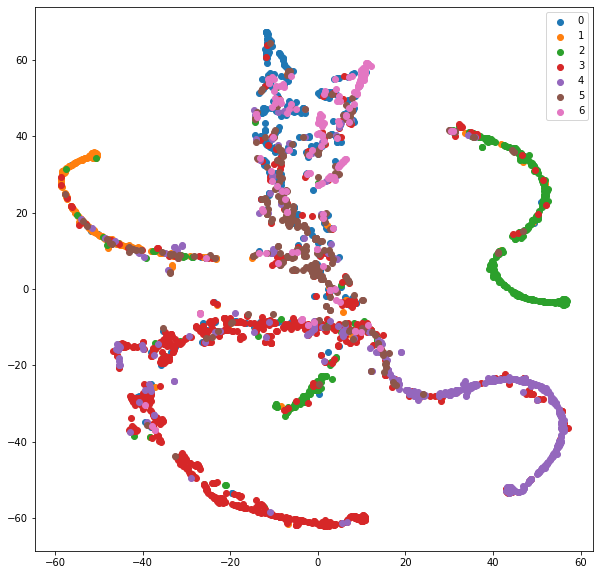

In [13]:
activ = inception_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Residual GCN

#### Build Model

In [14]:
residual_gcn_model = GCN(C.dropout,
                                activation='relu',
                                conv_activation='relu',
                                mode=None,
                                sc='sc')

residual_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 0s 445ms/step - loss: 1.9653 - acc: 0.1143 - val_loss: 1.8819 - val_acc: 0.3100
Epoch 2/1000
1/1 [==============================] - 0s 32ms/step - loss: 1.8506 - acc: 0.2500 - val_loss: 1.8001 - val_acc: 0.4240
Epoch 3/1000
1/1 [==============================] - 0s 35ms/step - loss: 1.7790 - acc: 0.4071 - val_loss: 1.7034 - val_acc: 0.4940
Epoch 4/1000
1/1 [==============================] - 0s 35ms/step - loss: 1.7072 - acc: 0.5000 - val_loss: 1.6496 - val_acc: 0.4860
Epoch 5/1000
1/1 [==============================] - 0s 32ms/step - loss: 1.5893 - acc: 0.5929 - val_loss: 1.5882 - val_acc: 0.5320
Epoch 6/1000
1/1 [==============================] - 0s 31ms/step - loss: 1.4540 - acc: 0.6500 - val_loss: 1.5164 - val_acc: 0.5760
Epoch 7/1000
1/1 [==============================] - 0s 32ms/step 

1/1 [==============================] - 0s 33ms/step - loss: 0.2346 - acc: 0.9786 - val_loss: 1.0117 - val_acc: 0.7580
Epoch 56/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1949 - acc: 1.0000 - val_loss: 1.0129 - val_acc: 0.7640
Epoch 57/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1701 - acc: 0.9929 - val_loss: 1.0148 - val_acc: 0.7680
Epoch 58/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2121 - acc: 0.9786 - val_loss: 1.0178 - val_acc: 0.7700
Epoch 59/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1705 - acc: 1.0000 - val_loss: 1.0221 - val_acc: 0.7680
Epoch 60/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1783 - acc: 0.9929 - val_loss: 1.0270 - val_acc: 0.7660
Epoch 61/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2035 - acc: 0.9786 - val_loss: 1.0309 - val_acc: 0.7640
Epoch 62/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.1638 - acc: 1.

1/1 [==============================] - 0s 32ms/step - loss: 0.0655 - acc: 0.9929 - val_loss: 1.1038 - val_acc: 0.7600
Epoch 118/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0622 - acc: 1.0000 - val_loss: 1.1054 - val_acc: 0.7660
Epoch 119/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.0993 - acc: 0.9929 - val_loss: 1.1075 - val_acc: 0.7660
Epoch 120/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0782 - acc: 1.0000 - val_loss: 1.1094 - val_acc: 0.7660
Epoch 121/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.0774 - acc: 0.9929 - val_loss: 1.1118 - val_acc: 0.7660
Epoch 122/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0677 - acc: 1.0000 - val_loss: 1.1153 - val_acc: 0.7660
Epoch 123/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.0524 - acc: 1.0000 - val_loss: 1.1190 - val_acc: 0.7660
Epoch 124/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0441 - 

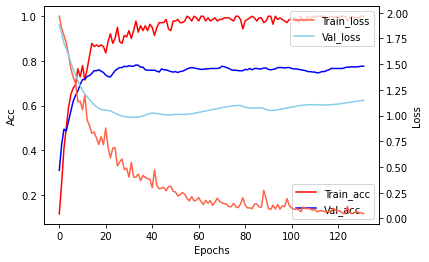

In [15]:
residual_gcn_history = residual_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(residual_gcn_history, 'ResidualGCN', issave=False)

#### Evaluate

In [16]:
y_pred = residual_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Residual GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Residual GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.71      0.72      0.71       351
    Genetic_Algorithms       0.83      0.83      0.83       217
       Neural_Networks       0.91      0.88      0.89       418
 Probabilistic_Methods       0.83      0.83      0.83       818
Reinforcement_Learning       0.88      0.70      0.78       426
         Rule_Learning       0.66      0.81      0.73       298
                Theory       0.67      0.76      0.71       180

              accuracy                           0.79      2708
             macro avg       0.78      0.79      0.78      2708
          weighted avg       0.80      0.79      0.80      2708



#### Visualization

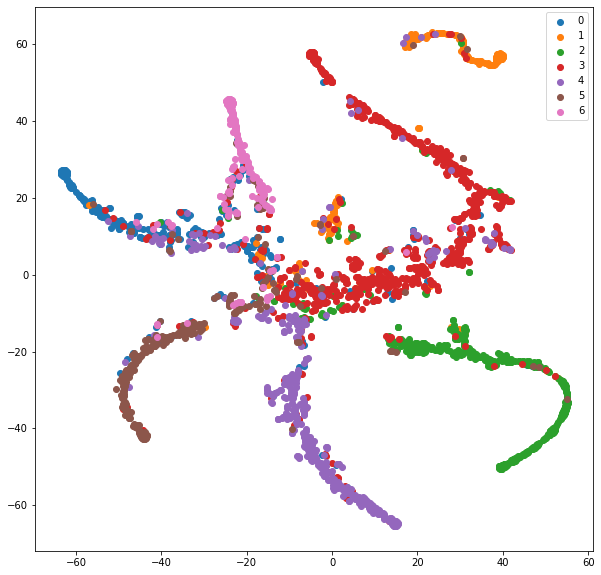

In [17]:
activ = residual_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Attention GCN

#### Build Model

In [18]:
attention_gcn_model = GCN(C.dropout,
                                activation='relu',
                                conv_activation='relu',
                                mode='attention',
                                sc=None,
                         attn_heads=8,
                         concat_heads=False)

attention_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 2s 2s/step - loss: 1.9459 - acc: 0.1857 - val_loss: 1.9459 - val_acc: 0.3220
Epoch 2/1000
1/1 [==============================] - 0s 54ms/step - loss: 1.9459 - acc: 0.3500 - val_loss: 1.9458 - val_acc: 0.5080
Epoch 3/1000
1/1 [==============================] - 0s 52ms/step - loss: 1.9457 - acc: 0.4143 - val_loss: 1.9455 - val_acc: 0.4760
Epoch 4/1000
1/1 [==============================] - 0s 54ms/step - loss: 1.9455 - acc: 0.4071 - val_loss: 1.9452 - val_acc: 0.5220
Epoch 5/1000
1/1 [==============================] - 0s 54ms/step - loss: 1.9452 - acc: 0.4500 - val_loss: 1.9448 - val_acc: 0.6240
Epoch 6/1000
1/1 [==============================] - 0s 54ms/step - loss: 1.9447 - acc: 0.5286 - val_loss: 1.9441 - val_acc: 0.6760
Epoch 7/1000
1/1 [==============================] - 0s 56ms/step - l

1/1 [==============================] - 0s 55ms/step - loss: 1.2776 - acc: 0.8929 - val_loss: 1.5118 - val_acc: 0.8000
Epoch 53/1000
1/1 [==============================] - 0s 54ms/step - loss: 1.2579 - acc: 0.8857 - val_loss: 1.4915 - val_acc: 0.8020
Epoch 54/1000
1/1 [==============================] - 0s 54ms/step - loss: 1.2046 - acc: 0.9143 - val_loss: 1.4712 - val_acc: 0.8020
Epoch 55/1000
1/1 [==============================] - 0s 55ms/step - loss: 1.2351 - acc: 0.8714 - val_loss: 1.4505 - val_acc: 0.8040
Epoch 56/1000
1/1 [==============================] - 0s 56ms/step - loss: 1.1751 - acc: 0.9214 - val_loss: 1.4299 - val_acc: 0.8060
Epoch 57/1000
1/1 [==============================] - 0s 55ms/step - loss: 1.1399 - acc: 0.8929 - val_loss: 1.4094 - val_acc: 0.8080
Epoch 58/1000
1/1 [==============================] - 0s 56ms/step - loss: 1.0921 - acc: 0.8929 - val_loss: 1.3891 - val_acc: 0.8080
Epoch 59/1000
1/1 [==============================] - 0s 56ms/step - loss: 1.1065 - acc: 0.

1/1 [==============================] - 0s 53ms/step - loss: 0.3640 - acc: 0.9500 - val_loss: 0.8596 - val_acc: 0.7980
Epoch 115/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3262 - acc: 0.9929 - val_loss: 0.8559 - val_acc: 0.8000
Epoch 116/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.4164 - acc: 0.9071 - val_loss: 0.8522 - val_acc: 0.7980
Epoch 117/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3877 - acc: 0.9571 - val_loss: 0.8483 - val_acc: 0.7980
Epoch 118/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.4012 - acc: 0.9286 - val_loss: 0.8454 - val_acc: 0.7980
Epoch 119/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3523 - acc: 0.9786 - val_loss: 0.8427 - val_acc: 0.7980
Epoch 120/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3398 - acc: 0.9500 - val_loss: 0.8402 - val_acc: 0.7980
Epoch 121/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3186 - 

Epoch 176/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.1968 - acc: 0.9643 - val_loss: 0.7696 - val_acc: 0.7880
Epoch 177/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2309 - acc: 0.9500 - val_loss: 0.7696 - val_acc: 0.7880
Epoch 178/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2005 - acc: 0.9857 - val_loss: 0.7692 - val_acc: 0.7880
Epoch 179/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2791 - acc: 0.9571 - val_loss: 0.7680 - val_acc: 0.7880
Epoch 180/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2136 - acc: 0.9643 - val_loss: 0.7664 - val_acc: 0.7900
Epoch 181/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.1918 - acc: 0.9643 - val_loss: 0.7651 - val_acc: 0.7900
Epoch 182/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1976 - acc: 0.9857 - val_loss: 0.7640 - val_acc: 0.7900
Epoch 183/1000
1/1 [==============================] - 0s 55ms/step - 

1/1 [==============================] - 0s 57ms/step - loss: 0.1159 - acc: 0.9929 - val_loss: 0.7543 - val_acc: 0.7860
Epoch 238/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.1379 - acc: 0.9714 - val_loss: 0.7538 - val_acc: 0.7860
Epoch 239/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.1419 - acc: 0.9857 - val_loss: 0.7532 - val_acc: 0.7860
Epoch 240/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1743 - acc: 0.9714 - val_loss: 0.7528 - val_acc: 0.7860
Epoch 241/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.1409 - acc: 0.9714 - val_loss: 0.7521 - val_acc: 0.7880
Epoch 242/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.1083 - acc: 0.9786 - val_loss: 0.7512 - val_acc: 0.7880
Epoch 243/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.1246 - acc: 0.9929 - val_loss: 0.7503 - val_acc: 0.7880
Epoch 244/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1406 - 

Epoch 299/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1035 - acc: 0.9929 - val_loss: 0.7435 - val_acc: 0.7800
Epoch 300/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1324 - acc: 0.9929 - val_loss: 0.7434 - val_acc: 0.7800
Epoch 301/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0963 - acc: 0.9929 - val_loss: 0.7435 - val_acc: 0.7820
Epoch 302/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.1568 - acc: 0.9857 - val_loss: 0.7438 - val_acc: 0.7780
Epoch 303/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0882 - acc: 0.9857 - val_loss: 0.7443 - val_acc: 0.7800
Epoch 304/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.1402 - acc: 0.9643 - val_loss: 0.7447 - val_acc: 0.7800
Epoch 305/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.1383 - acc: 0.9714 - val_loss: 0.7448 - val_acc: 0.7800
Epoch 306/1000
1/1 [==============================] - 0s 52ms/step - 

1/1 [==============================] - 0s 56ms/step - loss: 0.0992 - acc: 0.9857 - val_loss: 0.7485 - val_acc: 0.7740
Epoch 361/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1036 - acc: 0.9857 - val_loss: 0.7483 - val_acc: 0.7740
Epoch 362/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0577 - acc: 1.0000 - val_loss: 0.7481 - val_acc: 0.7740
Epoch 363/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0827 - acc: 0.9857 - val_loss: 0.7482 - val_acc: 0.7740
Epoch 364/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0659 - acc: 0.9929 - val_loss: 0.7482 - val_acc: 0.7740
Epoch 365/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.1043 - acc: 0.9714 - val_loss: 0.7484 - val_acc: 0.7740
Epoch 366/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0887 - acc: 1.0000 - val_loss: 0.7483 - val_acc: 0.7740
Epoch 367/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0765 - 

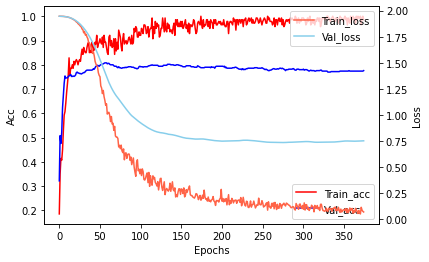

In [19]:
attention_gcn_history = attention_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(attention_gcn_history, 'AttentionGCN', issave=False)

#### Evaluate

In [20]:
y_pred = attention_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Attention GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Attention GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.67      0.78      0.72       351
    Genetic_Algorithms       0.72      0.85      0.78       217
       Neural_Networks       0.86      0.91      0.89       418
 Probabilistic_Methods       0.92      0.76      0.83       818
Reinforcement_Learning       0.81      0.81      0.81       426
         Rule_Learning       0.82      0.77      0.79       298
                Theory       0.69      0.85      0.76       180

              accuracy                           0.81      2708
             macro avg       0.78      0.82      0.80      2708
          weighted avg       0.82      0.81      0.81      2708



#### Visualization

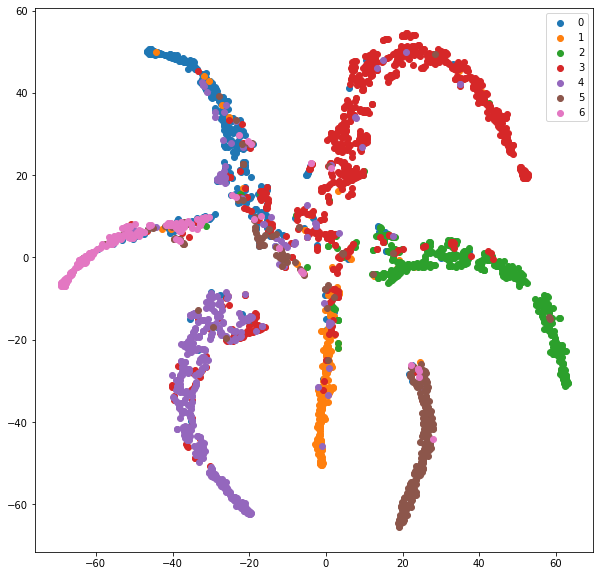

In [21]:
activ = attention_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Gated Skip Connection GCN

#### Build Model

In [22]:
gated_skip_connection_gcn_model = GCN(C.dropout,
                                activation='relu',
                                conv_activation='relu',
                                mode=None,
                                sc='gsc',
                         attn_heads=8,
                         concat_heads=False)

gated_skip_connection_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 1s 656ms/step - loss: 1.9427 - acc: 0.1571 - val_loss: 1.9169 - val_acc: 0.1840
Epoch 2/1000
1/1 [==============================] - 0s 85ms/step - loss: 1.9269 - acc: 0.3000 - val_loss: 1.8917 - val_acc: 0.3060
Epoch 3/1000
1/1 [==============================] - 0s 85ms/step - loss: 1.8500 - acc: 0.4071 - val_loss: 1.8862 - val_acc: 0.2720
Epoch 4/1000
1/1 [==============================] - 0s 88ms/step - loss: 1.7622 - acc: 0.5429 - val_loss: 1.8727 - val_acc: 0.2500
Epoch 5/1000
1/1 [==============================] - 0s 86ms/step - loss: 1.6989 - acc: 0.5286 - val_loss: 1.8560 - val_acc: 0.2940
Epoch 6/1000
1/1 [==============================] - 0s 87ms/step - loss: 1.6153 - acc: 0.6500 - val_loss: 1.8540 - val_acc: 0.3020
Epoch 7/1000
1/1 [==============================] - 0s 88ms/step 

1/1 [==============================] - 0s 86ms/step - loss: 0.3760 - acc: 0.9071 - val_loss: 2.0106 - val_acc: 0.4260
Epoch 63/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3529 - acc: 0.9429 - val_loss: 2.0074 - val_acc: 0.4280
Epoch 64/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3792 - acc: 0.9071 - val_loss: 2.0077 - val_acc: 0.4240
Epoch 65/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.4208 - acc: 0.9143 - val_loss: 2.0005 - val_acc: 0.4320
Epoch 66/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3989 - acc: 0.9214 - val_loss: 1.9911 - val_acc: 0.4300
Epoch 67/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3468 - acc: 0.9357 - val_loss: 1.9918 - val_acc: 0.4340
Epoch 68/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.3365 - acc: 0.9571 - val_loss: 1.9952 - val_acc: 0.4380
Epoch 69/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3223 - acc: 0.

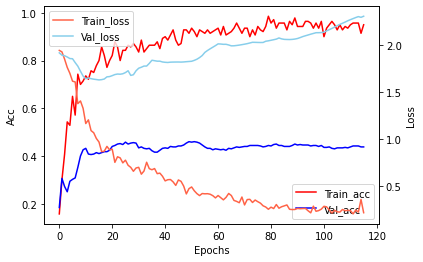

In [23]:
gated_skip_connection_gcn_history = gated_skip_connection_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(gated_skip_connection_gcn_history, 'GatedSkipConnectionGCN', issave=False)

#### Evaluate

In [24]:
y_pred = gated_skip_connection_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Gated skip conncetion GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Gated skip conncetion GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.27      0.77      0.40       351
    Genetic_Algorithms       0.47      0.53      0.50       217
       Neural_Networks       0.54      0.39      0.45       418
 Probabilistic_Methods       0.53      0.42      0.47       818
Reinforcement_Learning       0.69      0.08      0.14       426
         Rule_Learning       0.64      0.46      0.54       298
                Theory       0.47      0.59      0.52       180

              accuracy                           0.43      2708
             macro avg       0.52      0.46      0.43      2708
          weighted avg       0.53      0.43      0.42      2708



#### Visualization

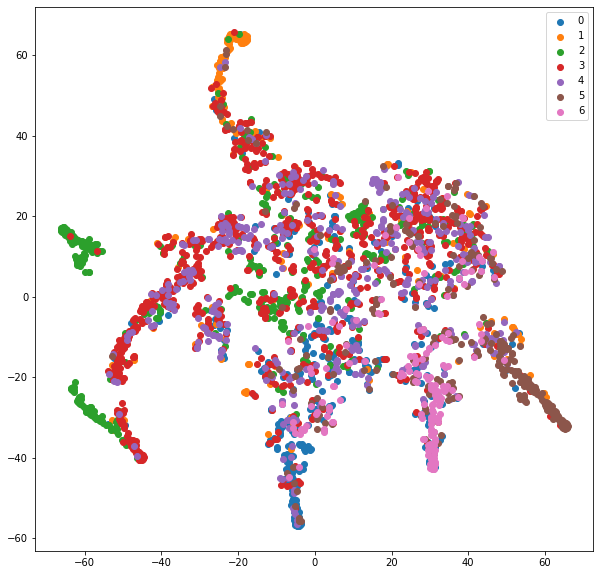

In [25]:
activ = gated_skip_connection_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Residual + inception GCN

#### Build Model

In [26]:
residual_inception_gcn_model = GCN(C.dropout,
                                activation='relu',
                                conv_activation='relu',
                                mode='inception',
                                sc='sc',
                         attn_heads=8,
                         concat_heads=False)

residual_inception_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 1s 724ms/step - loss: 344.5569 - acc: 0.1357 - val_loss: 298.0891 - val_acc: 0.2860
Epoch 2/1000
1/1 [==============================] - 0s 97ms/step - loss: 161.1488 - acc: 0.1286 - val_loss: 592.0924 - val_acc: 0.1140
Epoch 3/1000
1/1 [==============================] - 0s 98ms/step - loss: 449.3641 - acc: 0.1500 - val_loss: 497.0760 - val_acc: 0.1140
Epoch 4/1000
1/1 [==============================] - 0s 100ms/step - loss: 320.8180 - acc: 0.1357 - val_loss: 306.8118 - val_acc: 0.1140
Epoch 5/1000
1/1 [==============================] - 0s 101ms/step - loss: 122.5695 - acc: 0.1571 - val_loss: 105.0437 - val_acc: 0.1680
Epoch 6/1000
1/1 [==============================] - 0s 102ms/step - loss: 31.7703 - acc: 0.1714 - val_loss: 18.2166 - val_acc: 0.2940
Epoch 7/1000
1/1 [======================

1/1 [==============================] - 0s 100ms/step - loss: 1.6893 - acc: 0.5000 - val_loss: 1.8993 - val_acc: 0.3840
Epoch 55/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.6997 - acc: 0.5143 - val_loss: 1.8918 - val_acc: 0.3880
Epoch 56/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.7099 - acc: 0.4571 - val_loss: 1.8849 - val_acc: 0.3900
Epoch 57/1000
1/1 [==============================] - 0s 97ms/step - loss: 1.6913 - acc: 0.4500 - val_loss: 1.8771 - val_acc: 0.3880
Epoch 58/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.6606 - acc: 0.5214 - val_loss: 1.8703 - val_acc: 0.3840
Epoch 59/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.6679 - acc: 0.5071 - val_loss: 1.8634 - val_acc: 0.3880
Epoch 60/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.6640 - acc: 0.4857 - val_loss: 1.8568 - val_acc: 0.3880
Epoch 61/1000
1/1 [==============================] - 0s 100ms/step - loss: 1.6652 - acc:

Epoch 116/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.1792 - acc: 0.7357 - val_loss: 1.4326 - val_acc: 0.6280
Epoch 117/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.1252 - acc: 0.7714 - val_loss: 1.4178 - val_acc: 0.6360
Epoch 118/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.1346 - acc: 0.7714 - val_loss: 1.4015 - val_acc: 0.6520
Epoch 119/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.1151 - acc: 0.7643 - val_loss: 1.3935 - val_acc: 0.6480
Epoch 120/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.0693 - acc: 0.7786 - val_loss: 1.3891 - val_acc: 0.6560
Epoch 121/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.1246 - acc: 0.7857 - val_loss: 1.3883 - val_acc: 0.6560
Epoch 122/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.1054 - acc: 0.7929 - val_loss: 1.3822 - val_acc: 0.6580
Epoch 123/1000
1/1 [==============================] - 0s 100ms/st

1/1 [==============================] - 0s 101ms/step - loss: 0.7261 - acc: 0.8500 - val_loss: 1.1973 - val_acc: 0.7120
Epoch 178/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.6443 - acc: 0.9143 - val_loss: 1.1930 - val_acc: 0.7180
Epoch 179/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.6412 - acc: 0.8714 - val_loss: 1.1898 - val_acc: 0.7140
Epoch 180/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.6674 - acc: 0.8786 - val_loss: 1.1871 - val_acc: 0.7140
Epoch 181/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.6146 - acc: 0.8857 - val_loss: 1.1848 - val_acc: 0.7140
Epoch 182/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.6680 - acc: 0.8714 - val_loss: 1.1834 - val_acc: 0.7140
Epoch 183/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.6125 - acc: 0.9000 - val_loss: 1.1836 - val_acc: 0.7180
Epoch 184/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.6527 

1/1 [==============================] - 0s 97ms/step - loss: 0.5095 - acc: 0.9214 - val_loss: 1.2126 - val_acc: 0.7220
Epoch 239/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.5126 - acc: 0.9286 - val_loss: 1.2121 - val_acc: 0.7240
Epoch 240/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.5164 - acc: 0.9286 - val_loss: 1.2134 - val_acc: 0.7260
Epoch 241/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.4743 - acc: 0.9214 - val_loss: 1.2159 - val_acc: 0.7260
Epoch 242/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.4757 - acc: 0.9214 - val_loss: 1.2202 - val_acc: 0.7200
Epoch 243/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.5241 - acc: 0.9143 - val_loss: 1.2256 - val_acc: 0.7160
Epoch 244/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.5261 - acc: 0.8929 - val_loss: 1.2303 - val_acc: 0.7140
Epoch 245/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.4512 -

1/1 [==============================] - 0s 97ms/step - loss: 0.3441 - acc: 0.9714 - val_loss: 1.2859 - val_acc: 0.7220
Epoch 300/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.3597 - acc: 0.9643 - val_loss: 1.2894 - val_acc: 0.7220
Epoch 301/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.3551 - acc: 0.9571 - val_loss: 1.2939 - val_acc: 0.7200
Epoch 302/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.3600 - acc: 0.9643 - val_loss: 1.2975 - val_acc: 0.7180
Epoch 303/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.3678 - acc: 0.9643 - val_loss: 1.3010 - val_acc: 0.7160
Epoch 304/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.3737 - acc: 0.9571 - val_loss: 1.3056 - val_acc: 0.7200
Epoch 305/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.3435 - acc: 0.9571 - val_loss: 1.3107 - val_acc: 0.7180
Epoch 306/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.3511 - 

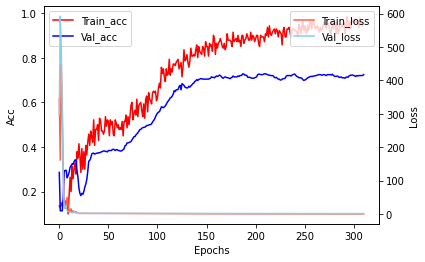

In [27]:
residual_inception_gcn_history = residual_inception_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(residual_inception_gcn_history, 'ResidualInceptionGCN', issave=False)

#### Evaluate

In [28]:
y_pred = residual_inception_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Residual Inception GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Residual Inception GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.63      0.74      0.68       351
    Genetic_Algorithms       0.84      0.71      0.77       217
       Neural_Networks       0.64      0.95      0.77       418
 Probabilistic_Methods       0.89      0.56      0.69       818
Reinforcement_Learning       0.68      0.77      0.73       426
         Rule_Learning       0.87      0.73      0.79       298
                Theory       0.56      0.79      0.65       180

              accuracy                           0.72      2708
             macro avg       0.73      0.75      0.73      2708
          weighted avg       0.76      0.72      0.72      2708



#### Visualization

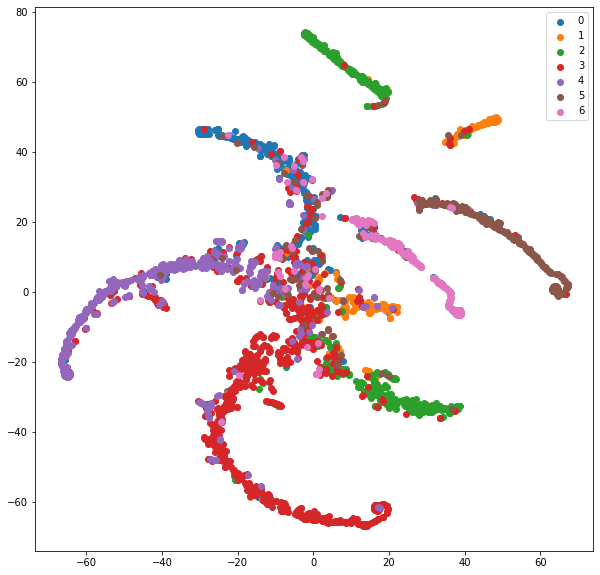

In [29]:
activ = residual_inception_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Residual + Attention GCN

#### Build Model

In [30]:
residual_attention_gcn_model = GCN(C.dropout,
                                activation='relu',
                                conv_activation='relu',
                                mode='attention',
                                sc='sc',
                         attn_heads=8,
                         concat_heads=False)

residual_attention_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 1s 1s/step - loss: 1.9463 - acc: 0.1357 - val_loss: 1.9438 - val_acc: 0.1980
Epoch 2/1000
1/1 [==============================] - 0s 53ms/step - loss: 1.9392 - acc: 0.2714 - val_loss: 1.9411 - val_acc: 0.2480
Epoch 3/1000
1/1 [==============================] - 0s 55ms/step - loss: 1.9365 - acc: 0.2357 - val_loss: 1.9376 - val_acc: 0.2960
Epoch 4/1000
1/1 [==============================] - 0s 56ms/step - loss: 1.9264 - acc: 0.3143 - val_loss: 1.9330 - val_acc: 0.3420
Epoch 5/1000
1/1 [==============================] - 0s 58ms/step - loss: 1.9150 - acc: 0.3714 - val_loss: 1.9273 - val_acc: 0.3700
Epoch 6/1000
1/1 [==============================] - 0s 57ms/step - loss: 1.9033 - acc: 0.4286 - val_loss: 1.9203 - val_acc: 0.3940
Epoch 7/1000
1/1 [==============================] - 0s 54ms/step - l

1/1 [==============================] - 0s 58ms/step - loss: 0.5866 - acc: 0.8929 - val_loss: 1.0985 - val_acc: 0.7120
Epoch 55/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.5230 - acc: 0.9429 - val_loss: 1.0837 - val_acc: 0.7160
Epoch 56/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.5177 - acc: 0.9500 - val_loss: 1.0696 - val_acc: 0.7220
Epoch 57/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.4457 - acc: 0.9571 - val_loss: 1.0556 - val_acc: 0.7220
Epoch 58/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.4523 - acc: 0.9286 - val_loss: 1.0428 - val_acc: 0.7220
Epoch 59/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.4085 - acc: 0.9500 - val_loss: 1.0308 - val_acc: 0.7240
Epoch 60/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3774 - acc: 0.9643 - val_loss: 1.0195 - val_acc: 0.7280
Epoch 61/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.4503 - acc: 0.

1/1 [==============================] - 0s 57ms/step - loss: 0.1621 - acc: 0.9643 - val_loss: 0.7597 - val_acc: 0.7700
Epoch 117/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.1832 - acc: 0.9571 - val_loss: 0.7594 - val_acc: 0.7700
Epoch 118/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.1635 - acc: 0.9786 - val_loss: 0.7584 - val_acc: 0.7680
Epoch 119/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1533 - acc: 0.9643 - val_loss: 0.7571 - val_acc: 0.7680
Epoch 120/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1296 - acc: 0.9786 - val_loss: 0.7561 - val_acc: 0.7640
Epoch 121/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1590 - acc: 0.9786 - val_loss: 0.7546 - val_acc: 0.7640
Epoch 122/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.2084 - acc: 0.9571 - val_loss: 0.7532 - val_acc: 0.7640
Epoch 123/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.1192 - 

Epoch 178/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0797 - acc: 0.9857 - val_loss: 0.7675 - val_acc: 0.7640
Epoch 179/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0761 - acc: 0.9929 - val_loss: 0.7686 - val_acc: 0.7620
Epoch 180/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0821 - acc: 0.9857 - val_loss: 0.7693 - val_acc: 0.7620
Epoch 181/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.1097 - acc: 0.9929 - val_loss: 0.7693 - val_acc: 0.7620
Epoch 182/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0915 - acc: 0.9857 - val_loss: 0.7689 - val_acc: 0.7600
Epoch 183/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0888 - acc: 0.9929 - val_loss: 0.7681 - val_acc: 0.7580
Epoch 184/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1053 - acc: 0.9714 - val_loss: 0.7670 - val_acc: 0.7600
Epoch 185/1000
1/1 [==============================] - 0s 57ms/step - 

1/1 [==============================] - 0s 57ms/step - loss: 0.0709 - acc: 0.9929 - val_loss: 0.8019 - val_acc: 0.7540
Epoch 240/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1041 - acc: 0.9857 - val_loss: 0.8024 - val_acc: 0.7540
Epoch 241/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0755 - acc: 0.9714 - val_loss: 0.8020 - val_acc: 0.7580
Epoch 242/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0402 - acc: 0.9929 - val_loss: 0.8015 - val_acc: 0.7580
Epoch 243/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0471 - acc: 0.9857 - val_loss: 0.8009 - val_acc: 0.7540
Epoch 244/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0362 - acc: 0.9929 - val_loss: 0.8004 - val_acc: 0.7540
Epoch 245/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0714 - acc: 0.9857 - val_loss: 0.7996 - val_acc: 0.7540
Epoch 246/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0624 - 

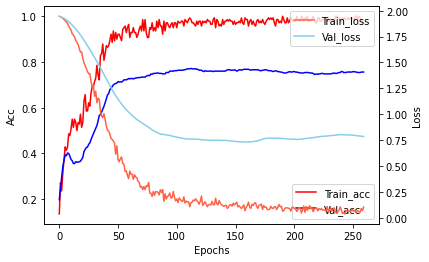

In [31]:
residual_attention_gcn_history = residual_attention_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(residual_attention_gcn_history, 'ResidualAttentionGCN', issave=False)

#### Evaluate

In [32]:
y_pred = residual_attention_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Residual Attention GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Residual Attention GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.70      0.73      0.71       351
    Genetic_Algorithms       0.64      0.89      0.74       217
       Neural_Networks       0.88      0.84      0.86       418
 Probabilistic_Methods       0.87      0.69      0.77       818
Reinforcement_Learning       0.69      0.85      0.76       426
         Rule_Learning       0.83      0.74      0.78       298
                Theory       0.71      0.76      0.74       180

              accuracy                           0.77      2708
             macro avg       0.76      0.79      0.77      2708
          weighted avg       0.79      0.77      0.77      2708



#### Visualization

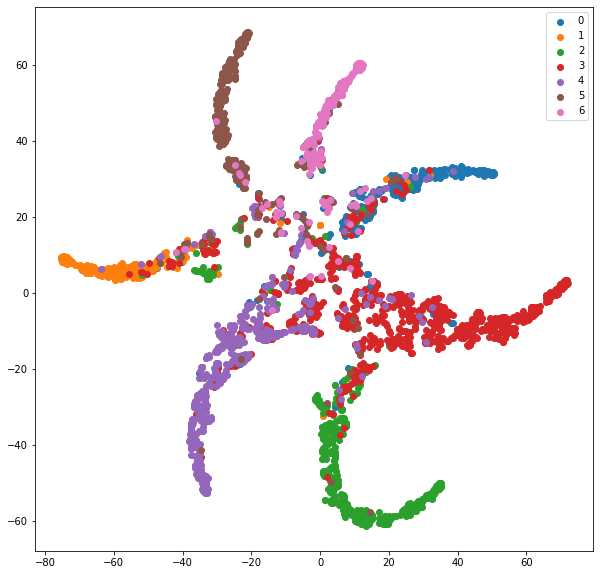

In [33]:
activ = residual_attention_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Gated Skip Connection + Inception GCN

#### Build Model

In [34]:
gated_skip_connection_inception_gcn_model = GCN(C.dropout,
                                activation='relu',
                                conv_activation='relu',
                                mode='inception',
                                sc='gsc',
                         attn_heads=8,
                         concat_heads=False)

gated_skip_connection_inception_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 1s 928ms/step - loss: 37.3424 - acc: 0.1857 - val_loss: 8.4317 - val_acc: 0.1280
Epoch 2/1000
1/1 [==============================] - 0s 157ms/step - loss: 10.4708 - acc: 0.1643 - val_loss: 10.1264 - val_acc: 0.1300
Epoch 3/1000
1/1 [==============================] - 0s 151ms/step - loss: 16.6572 - acc: 0.1857 - val_loss: 10.7605 - val_acc: 0.1340
Epoch 4/1000
1/1 [==============================] - 0s 152ms/step - loss: 14.3442 - acc: 0.2000 - val_loss: 8.8495 - val_acc: 0.1860
Epoch 5/1000
1/1 [==============================] - 0s 154ms/step - loss: 12.2868 - acc: 0.1857 - val_loss: 7.7905 - val_acc: 0.2120
Epoch 6/1000
1/1 [==============================] - 0s 163ms/step - loss: 8.2644 - acc: 0.2429 - val_loss: 6.4894 - val_acc: 0.1840
Epoch 7/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 149ms/step - loss: 1.6035 - acc: 0.5214 - val_loss: 2.4728 - val_acc: 0.3480
Epoch 62/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.5028 - acc: 0.5286 - val_loss: 3.3329 - val_acc: 0.3080
Epoch 63/1000
1/1 [==============================] - 0s 147ms/step - loss: 2.7763 - acc: 0.4714 - val_loss: 2.4171 - val_acc: 0.3420
Epoch 64/1000
1/1 [==============================] - 0s 155ms/step - loss: 1.5350 - acc: 0.5071 - val_loss: 2.2952 - val_acc: 0.3480
Epoch 65/1000
1/1 [==============================] - 0s 156ms/step - loss: 1.4767 - acc: 0.5571 - val_loss: 2.2752 - val_acc: 0.3520
Epoch 66/1000
1/1 [==============================] - 0s 158ms/step - loss: 1.5321 - acc: 0.5000 - val_loss: 2.2647 - val_acc: 0.3540
Epoch 67/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.5464 - acc: 0.5571 - val_loss: 2.2604 - val_acc: 0.3500
Epoch 68/1000
1/1 [==============================] - 0s 155ms/step - loss: 1.5536 -

1/1 [==============================] - 0s 152ms/step - loss: 1.1704 - acc: 0.6429 - val_loss: 2.6164 - val_acc: 0.3600
Epoch 123/1000
1/1 [==============================] - 0s 155ms/step - loss: 1.1859 - acc: 0.6071 - val_loss: 2.6247 - val_acc: 0.3580
Epoch 124/1000
1/1 [==============================] - 0s 156ms/step - loss: 1.1063 - acc: 0.6429 - val_loss: 2.6334 - val_acc: 0.3580
Epoch 125/1000
1/1 [==============================] - 0s 160ms/step - loss: 1.1006 - acc: 0.6286 - val_loss: 2.6424 - val_acc: 0.3600
Epoch 126/1000
1/1 [==============================] - 0s 155ms/step - loss: 1.1919 - acc: 0.6286 - val_loss: 2.6510 - val_acc: 0.3580
Epoch 127/1000
1/1 [==============================] - 0s 151ms/step - loss: 1.1816 - acc: 0.5786 - val_loss: 2.6702 - val_acc: 0.3600
Epoch 128/1000
1/1 [==============================] - 0s 155ms/step - loss: 1.1568 - acc: 0.6286 - val_loss: 2.6885 - val_acc: 0.3620
Epoch 129/1000
1/1 [==============================] - 0s 154ms/step - loss: 1

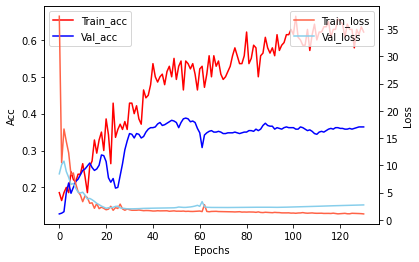

In [35]:
gated_skip_connection_inception_gcn_history = gated_skip_connection_inception_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(gated_skip_connection_inception_gcn_history, 'GatedSkipConnectionInceptionGCN', issave=False)

#### Evaluate

In [36]:
y_pred = gated_skip_connection_inception_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Gated skip conncetion Inception GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Gated skip conncetion Inception GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.15      0.10      0.12       351
    Genetic_Algorithms       0.67      0.41      0.51       217
       Neural_Networks       0.28      0.69      0.39       418
 Probabilistic_Methods       0.55      0.32      0.41       818
Reinforcement_Learning       0.29      0.06      0.09       426
         Rule_Learning       0.41      0.42      0.41       298
                Theory       0.30      0.67      0.41       180

              accuracy                           0.35      2708
             macro avg       0.38      0.38      0.34      2708
          weighted avg       0.39      0.35      0.33      2708



#### Visualization

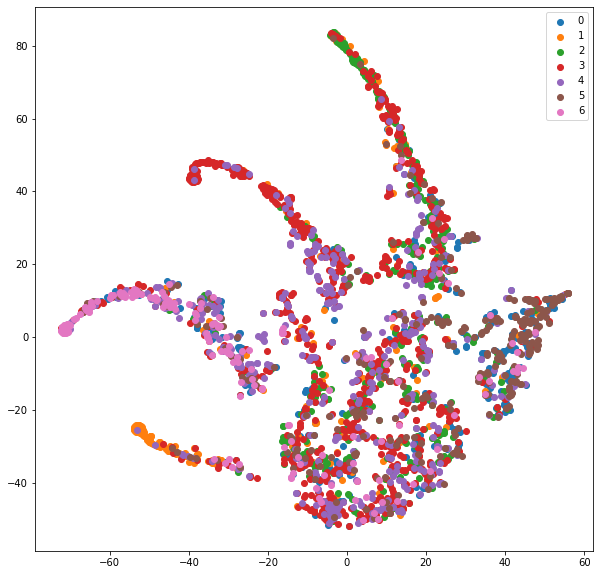

In [37]:
activ = gated_skip_connection_inception_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Gated Skip Connection + Attention GCN

#### Build Model

In [38]:
gated_skip_connection_attention_gcn_model = GCN(C.dropout,
                                activation='relu',
                                conv_activation='relu',
                                mode='attention',
                                sc='gsc',
                         attn_heads=8,
                         concat_heads=False)

gated_skip_connection_attention_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]
LOG >> input shape: [TensorShape([2708, 16]), TensorShape([2708, 2708])]
1/1 [==============================] - 1s 1s/step - loss: 1.9460 - acc: 0.1571 - val_loss: 1.9458 - val_acc: 0.1660
Epoch 2/1000
1/1 [==============================] - 0s 105ms/step - loss: 1.9449 - acc: 0.1786 - val_loss: 1.9455 - val_acc: 0.2200
Epoch 3/1000
1/1 [==============================] - 0s 107ms/step - loss: 1.9437 - acc: 0.3143 - val_loss: 1.9450 - val_acc: 0.2600
Epoch 4/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.9413 - acc: 0.3643 - val_loss: 1.9443 - val_acc: 0.3140
Epoch 5/1000
1/1 [==============================] - 0s 112ms/step - loss: 1.9395 - acc: 0.4286 - val_loss: 1.9435 - val_acc: 0.3520
Epoch 6/1000
1/1 [==============================] - 0s 113ms/step - loss: 1.9379 - acc: 0.4643 - val_loss: 1.9424 - val_acc: 0.3800
Epoch 7/1000
1/1 [==============================] - 0s 106ms/st

1/1 [==============================] - 0s 108ms/step - loss: 0.8399 - acc: 0.8643 - val_loss: 1.7618 - val_acc: 0.3760
Epoch 62/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.7700 - acc: 0.8786 - val_loss: 1.7603 - val_acc: 0.3680
Epoch 63/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.7442 - acc: 0.9214 - val_loss: 1.7578 - val_acc: 0.3720
Epoch 64/1000
1/1 [==============================] - 0s 107ms/step - loss: 0.7400 - acc: 0.9143 - val_loss: 1.7548 - val_acc: 0.3600
Epoch 65/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.7291 - acc: 0.9000 - val_loss: 1.7529 - val_acc: 0.3540
Epoch 66/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.6630 - acc: 0.9000 - val_loss: 1.7515 - val_acc: 0.3540
Epoch 67/1000
1/1 [==============================] - 0s 107ms/step - loss: 0.7204 - acc: 0.9286 - val_loss: 1.7493 - val_acc: 0.3500
Epoch 68/1000
1/1 [==============================] - 0s 106ms/step - loss: 0.6572 -

1/1 [==============================] - 0s 107ms/step - loss: 0.3539 - acc: 0.9214 - val_loss: 1.8385 - val_acc: 0.3140
Epoch 123/1000
1/1 [==============================] - 0s 106ms/step - loss: 0.3258 - acc: 0.9357 - val_loss: 1.8407 - val_acc: 0.3160
Epoch 124/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.2872 - acc: 0.9500 - val_loss: 1.8427 - val_acc: 0.3160
Epoch 125/1000
1/1 [==============================] - 0s 112ms/step - loss: 0.3624 - acc: 0.9357 - val_loss: 1.8448 - val_acc: 0.3160
Epoch 126/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.3114 - acc: 0.9071 - val_loss: 1.8464 - val_acc: 0.3180
Epoch 127/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.2796 - acc: 0.9429 - val_loss: 1.8480 - val_acc: 0.3180
Epoch 128/1000
1/1 [==============================] - 0s 106ms/step - loss: 0.3024 - acc: 0.9571 - val_loss: 1.8502 - val_acc: 0.3180
Epoch 129/1000
1/1 [==============================] - 0s 107ms/step - loss: 0

1/1 [==============================] - 0s 108ms/step - loss: 0.2439 - acc: 0.9500 - val_loss: 2.1315 - val_acc: 0.2980
Epoch 184/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.2840 - acc: 0.9429 - val_loss: 2.1327 - val_acc: 0.2960
Epoch 185/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.2736 - acc: 0.9500 - val_loss: 2.1337 - val_acc: 0.2940
Epoch 186/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.2141 - acc: 0.9500 - val_loss: 2.1349 - val_acc: 0.2960


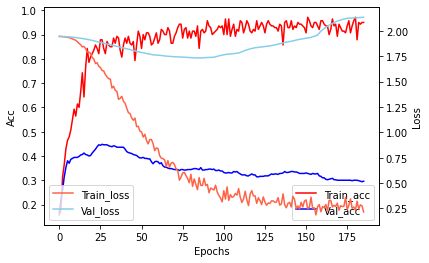

In [39]:
gated_skip_connection_attention_gcn_history = gated_skip_connection_attention_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(gated_skip_connection_attention_gcn_history, 'GatedSkipConnectionAttentionGCN', issave=False)

#### Evaluate

In [40]:
y_pred = gated_skip_connection_attention_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Gated skip conncetion Attention GCN Classification Report:\n{report}')
acc.append(float(report.split('\n')[-4].strip().split(' ')[-7]))

LOG >>> Gated skip conncetion Attention GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.74      0.09      0.16       351
    Genetic_Algorithms       0.54      0.27      0.36       217
       Neural_Networks       0.55      0.67      0.60       418
 Probabilistic_Methods       0.76      0.21      0.33       818
Reinforcement_Learning       0.30      0.72      0.43       426
         Rule_Learning       0.69      0.45      0.54       298
                Theory       0.19      0.64      0.29       180

              accuracy                           0.40      2708
             macro avg       0.54      0.43      0.39      2708
          weighted avg       0.59      0.40      0.39      2708



#### Visualization

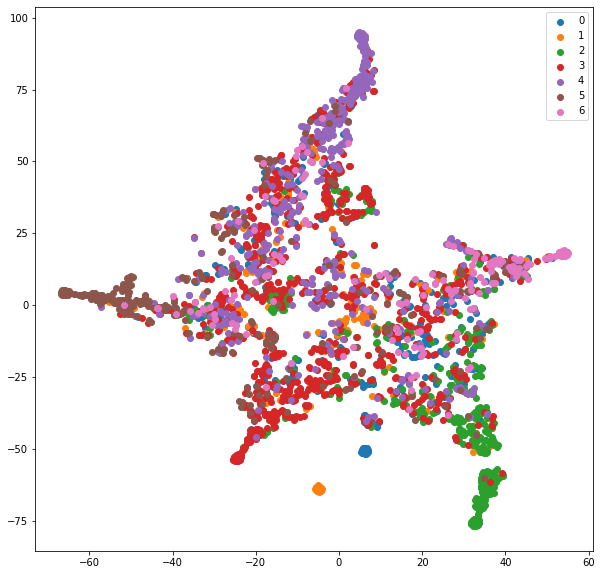

In [41]:
activ = gated_skip_connection_attention_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activ)

plot_tSNE(y_all, x_tsne)

# Result

In [45]:
acc.insert(0, 0.55)

In [47]:
label = [
    'DNN',
    'GCN',
    'Inception',
    'Residual',
    'Attention',
    'GatedSC',
    'I + R',
    'A + R',
    'I + GSC',
    'A + GSC'
]

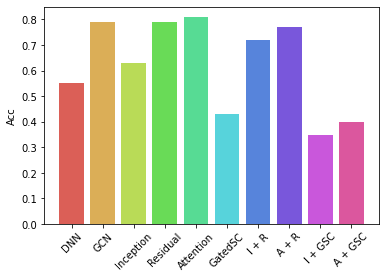

In [48]:
plt.bar(label, acc, color=sns.color_palette('hls', len(acc)))
plt.xticks(rotation=45)
plt.ylabel('Acc')
plt.show()